In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customers/extract - fees - data analyst - .csv
/kaggle/input/bank-customers/extract - cash request - data analyst.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [3]:
fees= pd.read_csv('/kaggle/input/bank-customers/extract - fees - data analyst - .csv')
cash_request= pd.read_csv('/kaggle/input/bank-customers/extract - cash request - data analyst.csv')

In [4]:
cash_request.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          23970 non-null  int64  
 1   amount                      23970 non-null  float64
 2   status                      23970 non-null  object 
 3   created_at                  23970 non-null  object 
 4   updated_at                  23970 non-null  object 
 5   user_id                     21867 non-null  float64
 6   moderated_at                16035 non-null  object 
 7   deleted_account_id          2104 non-null   float64
 8   reimbursement_date          23970 non-null  object 
 9   cash_request_received_date  16289 non-null  object 
 10  money_back_date             16543 non-null  object 
 11  transfer_type               23970 non-null  object 
 12  send_at                     16641 non-null  object 
 13  recovery_status             333

In [5]:
cr= cash_request.copy()
cr=cr[['amount','created_at', 'user_id', 'deleted_account_id', 'transfer_type']]
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   amount              23970 non-null  float64
 1   created_at          23970 non-null  object 
 2   user_id             21867 non-null  float64
 3   deleted_account_id  2104 non-null   float64
 4   transfer_type       23970 non-null  object 
dtypes: float64(3), object(2)
memory usage: 936.5+ KB


In [6]:
cr.fillna({'user_id':cr['deleted_account_id']}, inplace=True)
cr.drop(columns=['deleted_account_id'], inplace=True)
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   amount         23970 non-null  float64
 1   created_at     23970 non-null  object 
 2   user_id        23970 non-null  float64
 3   transfer_type  23970 non-null  object 
dtypes: float64(2), object(2)
memory usage: 749.2+ KB


In [7]:
cr['created_at']=pd.to_datetime(cr['created_at'])
cr.head()

,amount,created_at,user_id,transfer_type
0,100.0,2019-12-10 19:05:21.596873+00:00,804.0,regular
1,100.0,2019-12-10 19:50:12.347780+00:00,231.0,regular
2,100.0,2019-12-10 19:13:35.825460+00:00,191.0,regular
3,99.0,2019-12-10 19:16:10.880172+00:00,761.0,regular
4,100.0,2020-05-06 09:59:38.877376+00:00,7686.0,regular


In [8]:
cr['created_at']=cr['created_at'].dt.tz_localize(None)
cr.head()

,amount,created_at,user_id,transfer_type
0,100.0,2019-12-10 19:05:21.596873,804.0,regular
1,100.0,2019-12-10 19:50:12.347780,231.0,regular
2,100.0,2019-12-10 19:13:35.825460,191.0,regular
3,99.0,2019-12-10 19:16:10.880172,761.0,regular
4,100.0,2020-05-06 09:59:38.877376,7686.0,regular


In [9]:
cr['Month']=cr['created_at'].dt.to_period('M')
cr.head()

,amount,created_at,user_id,transfer_type,Month
0,100.0,2019-12-10 19:05:21.596873,804.0,regular,2019-12
1,100.0,2019-12-10 19:50:12.347780,231.0,regular,2019-12
2,100.0,2019-12-10 19:13:35.825460,191.0,regular,2019-12
3,99.0,2019-12-10 19:16:10.880172,761.0,regular,2019-12
4,100.0,2020-05-06 09:59:38.877376,7686.0,regular,2020-05


In [10]:
cr['Cohort']=cr.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
cr.head()

,amount,created_at,user_id,transfer_type,Month,Cohort
0,100.0,2019-12-10 19:05:21.596873,804.0,regular,2019-12,2019-12
1,100.0,2019-12-10 19:50:12.347780,231.0,regular,2019-12,2019-12
2,100.0,2019-12-10 19:13:35.825460,191.0,regular,2019-12,2019-12
3,99.0,2019-12-10 19:16:10.880172,761.0,regular,2019-12,2019-12
4,100.0,2020-05-06 09:59:38.877376,7686.0,regular,2020-05,2020-05


In [11]:
# calculate the number of the unique customers in each cohort
cohort_initial_sizes= cr.groupby('Cohort').agg(
    Number_of_initial_customers=('user_id', 'nunique')
).reset_index()
cohort_initial_sizes

,Cohort,Number_of_initial_customers
0,2019-11,1
1,2019-12,254
2,2020-01,106
3,2020-02,90
4,2020-03,86
5,2020-04,246
6,2020-05,432
7,2020-06,1540
8,2020-07,1482
9,2020-08,728


In [12]:
cohort_monthly_sizes= cr.groupby(['Cohort','Month']).agg(Number_of_customers=('user_id', 'nunique')).reset_index()
cohort_monthly_sizes

,Cohort,Month,Number_of_customers
0,2019-11,2019-11,1
1,2019-11,2019-12,1
2,2019-11,2020-04,1
3,2019-11,2020-05,1
4,2019-11,2020-08,1
...,...,...,...
78,2020-09,2020-10,680
79,2020-09,2020-11,20
80,2020-10,2020-10,4802
81,2020-10,2020-11,15


In [13]:
cohort_cash_monthly= cr.groupby(['Cohort','Month']).agg(Num_requests=('user_id', 'count')).reset_index()
cohort_cash_monthly

,Cohort,Month,Num_requests
0,2019-11,2019-11,1
1,2019-11,2019-12,1
2,2019-11,2020-04,1
3,2019-11,2020-05,1
4,2019-11,2020-08,1
...,...,...,...
78,2020-09,2020-10,727
79,2020-09,2020-11,20
80,2020-10,2020-10,5043
81,2020-10,2020-11,15


In [14]:
# calculate customer retention rate (unique customers per cohort in each month/initial customers in the cohort)
customers_retention= cohort_monthly_sizes.pivot(index='Cohort' , columns='Month' , values='Number_of_customers')
customers_retention= customers_retention.div(cohort_initial_sizes.set_index('Cohort')['Number_of_initial_customers'], axis=0)

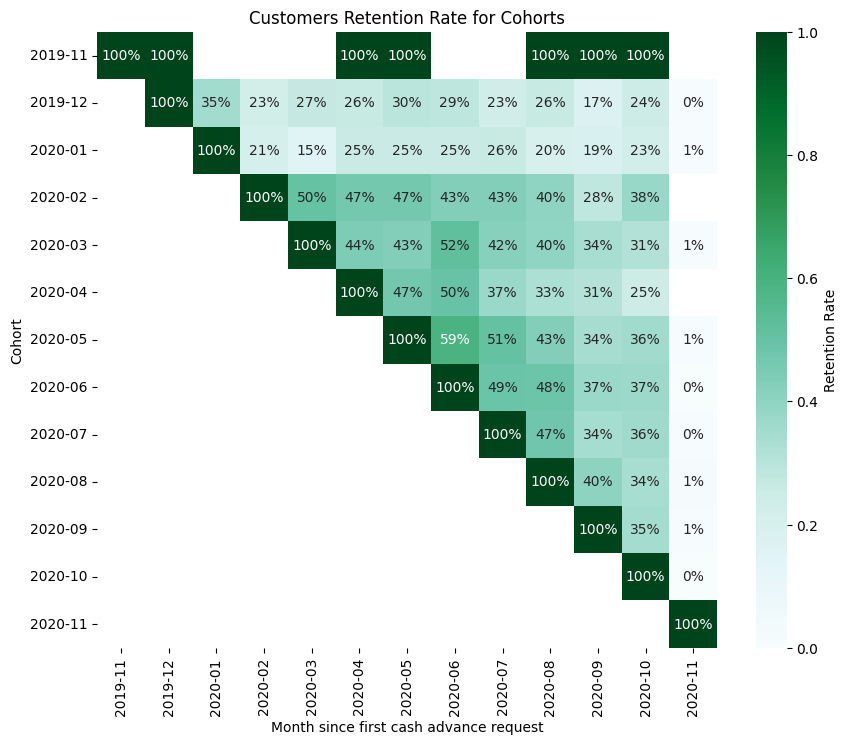

In [15]:
# Show the retention rate with heat map 
plt.figure(figsize=(10, 8))
plt.title('Customers Retention Rate for Cohorts')
sns.heatmap(data=customers_retention,
            annot=True,
            fmt='.0%',
            vmin=0.0,
            vmax=1.0,
            cmap='BuGn',
            cbar_kws={'label':'Retention Rate'})
plt.xlabel('Month since first cash advance request')
plt.ylabel('Cohort')
plt.show()

Text(95.72222222222221, 0.5, 'Cohort')

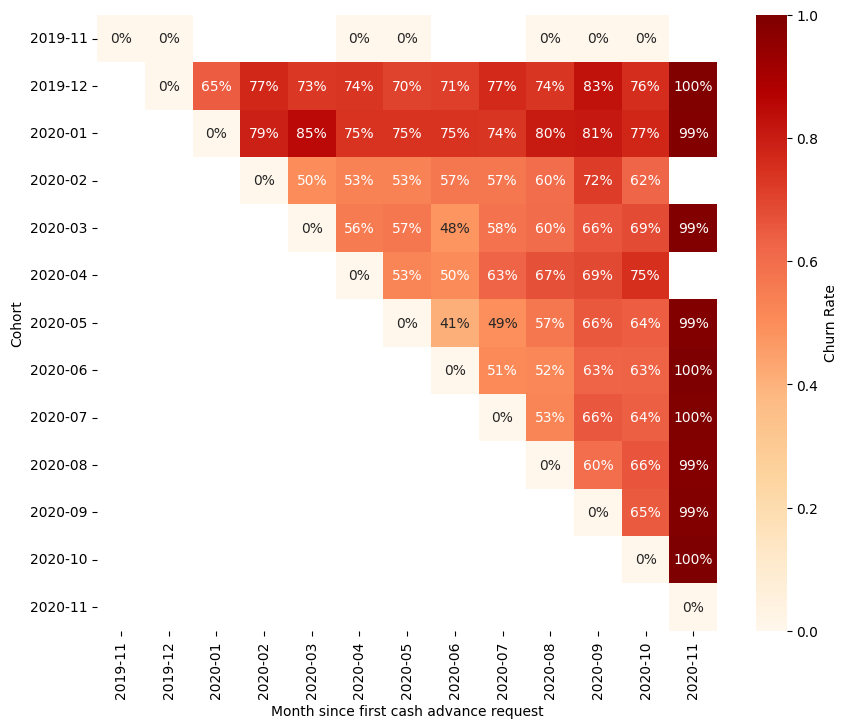

In [16]:
# calculate Churn Rate 
# Churn_rate= 1- retention_rate
churn_rate= 1- customers_retention

# plot the Churn rate 
plt.figure(figsize=(10, 8))
sns.heatmap(data=churn_rate,
            annot=True,
            fmt='.0%',
            vmin=0.0 ,
            vmax=1.0,
            cmap='OrRd',
            cbar_kws={'label':'Churn Rate'})
plt.xlabel('Month since first cash advance request')
plt.ylabel('Cohort')

In [17]:
# calculate the initial number of cash advance requests in each cohort
cohort_cash_initial= cohort_cash_monthly.groupby('Cohort').first().reset_index().rename(columns={'Num_requests':'Num_initial_requests'})
cohort_cash_initial

,Cohort,Month,Num_initial_requests
0,2019-11,2019-11,1
1,2019-12,2019-12,288
2,2020-01,2020-01,117
3,2020-02,2020-02,97
4,2020-03,2020-03,99
5,2020-04,2020-04,264
6,2020-05,2020-05,478
7,2020-06,2020-06,1934
8,2020-07,2020-07,1996
9,2020-08,2020-08,993


In [18]:
# Request Retention Rate (for Cohorts in Each Month/ Number of Initial Request of Cohort)
retention_request= cohort_cash_monthly.pivot(index='Cohort', columns='Month', values='Num_requests')
retention_request= retention_request.div(cohort_cash_initial.set_index('Cohort')['Num_initial_requests'], axis=0)
retention_request

Month,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohort,,,,,,,,,,,,,
2019-11,1.0,1.0,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.000000,2.000000,NaN
2019-12,NaN,1.0,0.368056,0.218750,0.274306,0.284722,0.298611,0.315972,0.250000,0.291667,0.184028,0.260417,0.003472
2020-01,NaN,NaN,1.000000,0.205128,0.145299,0.299145,0.264957,0.247863,0.264957,0.188034,0.188034,0.213675,0.008547
2020-02,NaN,NaN,NaN,1.000000,0.505155,0.505155,0.463918,0.463918,0.463918,0.453608,0.278351,0.412371,NaN
2020-03,NaN,NaN,NaN,NaN,1.000000,0.424242,0.464646,0.474747,0.404040,0.363636,0.303030,0.303030,0.010101
2020-04,NaN,NaN,NaN,NaN,NaN,1.000000,0.568182,0.571970,0.439394,0.405303,0.337121,0.284091,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.665272,0.573222,0.485356,0.376569,0.364017,0.008368
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.531024,0.494829,0.355222,0.339193,0.002585
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.471443,0.304609,0.298096,0.003507


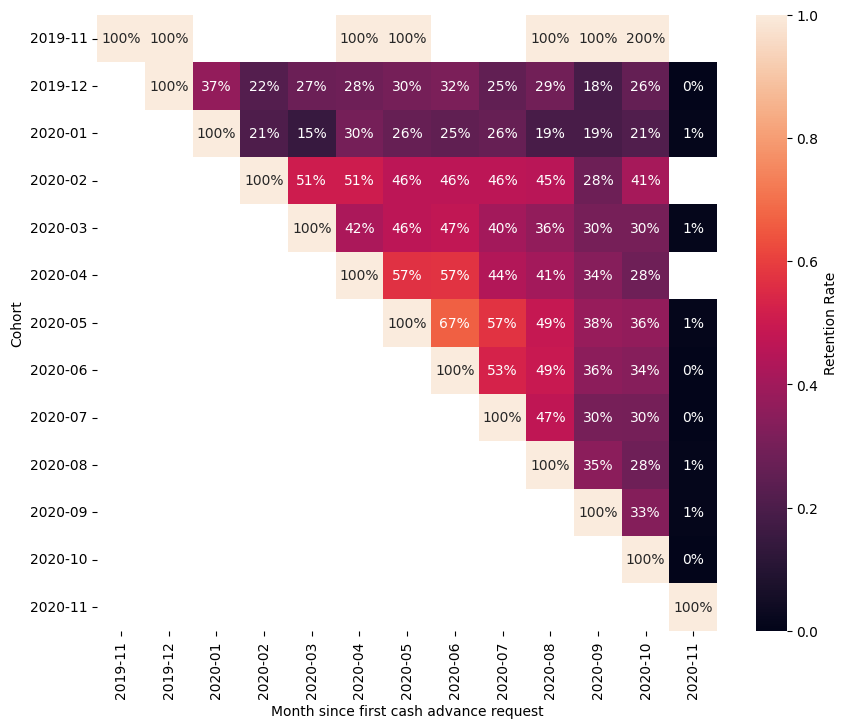

In [19]:
plt.figure(figsize=(10,8))
sns.color_palette("YlOrBr", as_cmap=True)
sns.heatmap(data=retention_request,
            annot=True,
            fmt='.0%',
            vmin=0.0,
            vmax=1.0,
            cbar_kws={'label':'Retention Rate'})
plt.xlabel('Month since first cash advance request')
plt.ylabel('Cohort')
plt.show()

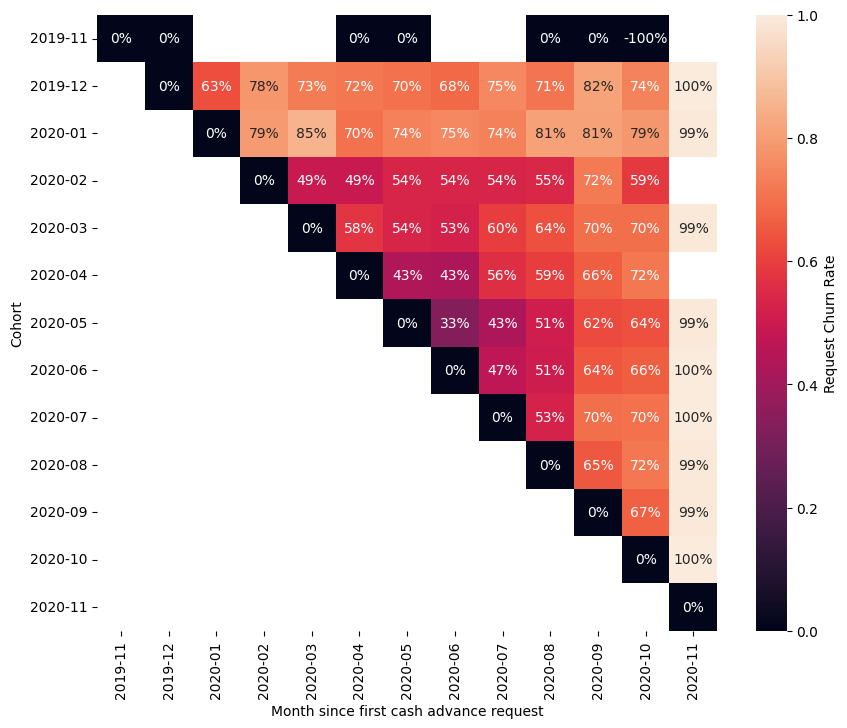

In [20]:
# Cash Request Churn Rate 
request_churn_rate = 1 - retention_request
plt.figure(figsize=(10,8))
sns.light_palette("seagreen", as_cmap=True)
sns.heatmap(data=request_churn_rate,
            annot=True,
            fmt='.0%',
            vmin=0.0,
            vmax=1.0,
            cbar_kws={'label':'Request Churn Rate'})
plt.xlabel('Month since first cash advance request')
plt.ylabel('Cohort')
plt.show()

In [21]:
cohort_2020_02 = retention_request.loc['2020-02']
df = cohort_2020_02.reset_index()
df.columns = ['Month', 'Retention_Rate']  # Renaming columns
df


# Convert 'Month' from Period to datetime
df['Month'] = df['Month'].astype(str)  # Convert to string
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')

# Convert 'Fecha_Compra' to numerical values (months since first purchase)
df['Month_Num'] = (df['Month'] - df['Month'].min()).dt.days // 30

df

,Month,Retention_Rate,Month_Num
0,2019-11-01,NaN,0
1,2019-12-01,NaN,1
2,2020-01-01,NaN,2
3,2020-02-01,1.000000,3
4,2020-03-01,0.505155,4
5,2020-04-01,0.505155,5
6,2020-05-01,0.463918,6
7,2020-06-01,0.463918,7
8,2020-07-01,0.463918,8
9,2020-08-01,0.453608,9


In [22]:
from sklearn.model_selection import KFold, train_test_split,cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

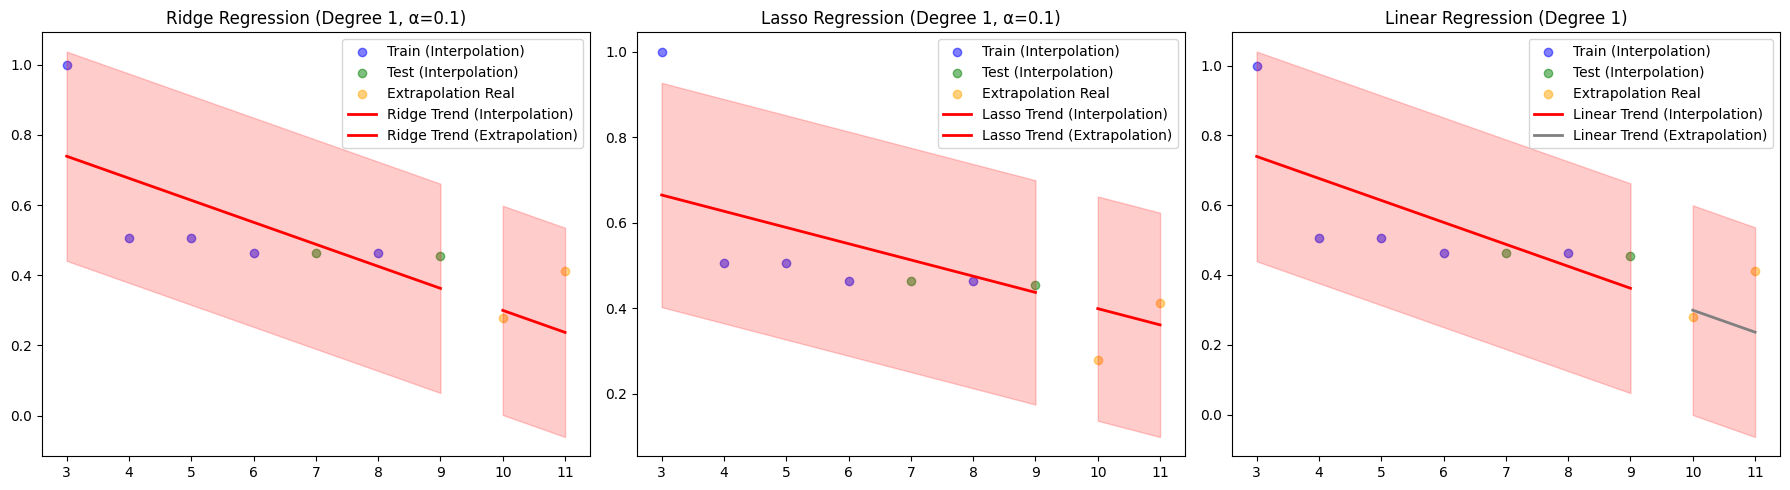

Degree 1: Ridge (α=0.1, MSE=-0.5033),R2_Score=-1.2388, R2_Score_Extrapolation=-2.4710466505684336
Degree 1: Lasso (α=0.1, MSE=-0.5459),R2_Score=-0.6452, R2_Score_Extrapolation=-0.9137484905204716
Degree 1: Linear (MSE=-0.5013),R2_Score=-1.2813, R2_Score_Extrapolation=-2.5107022098780334


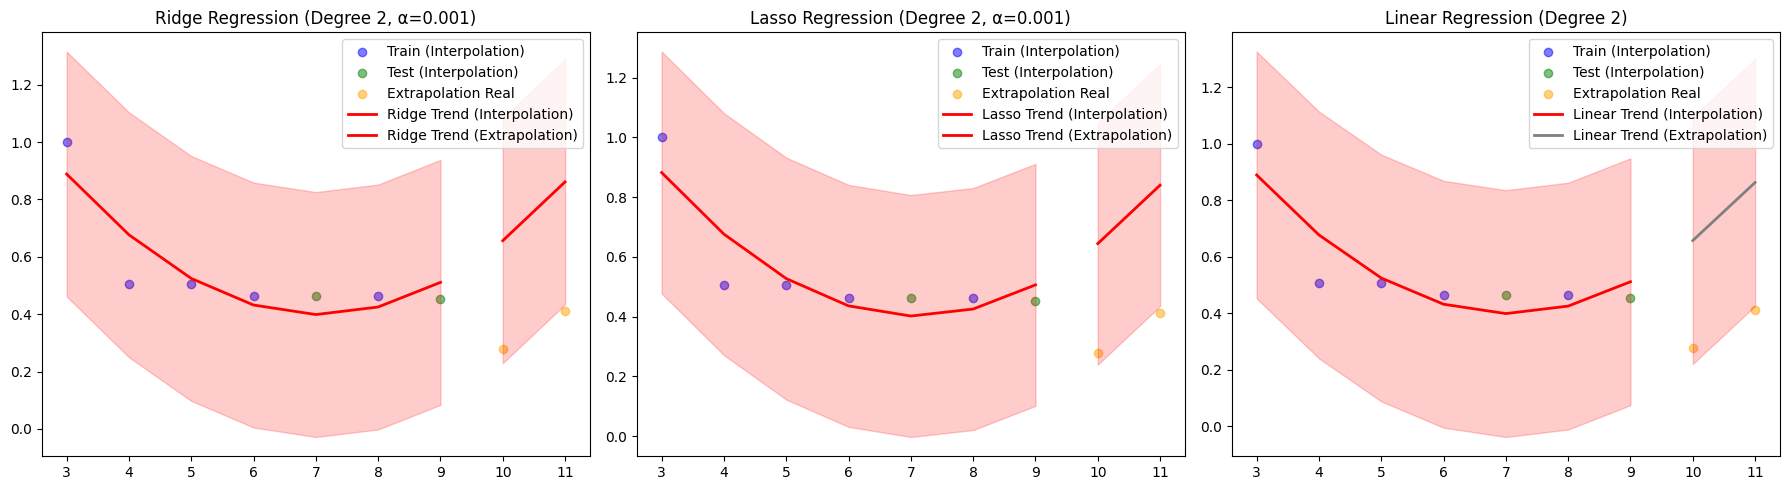

Degree 2: Ridge (α=0.001, MSE=-0.6646),R2_Score=-3.3919, R2_Score_Extrapolation=-37.317450272506036
Degree 2: Lasso (α=0.001, MSE=-0.6455),R2_Score=-2.9103, R2_Score_Extrapolation=-34.319374678374544
Degree 2: Linear (MSE=-0.6698),R2_Score=-3.6090, R2_Score_Extrapolation=-37.49275449824915


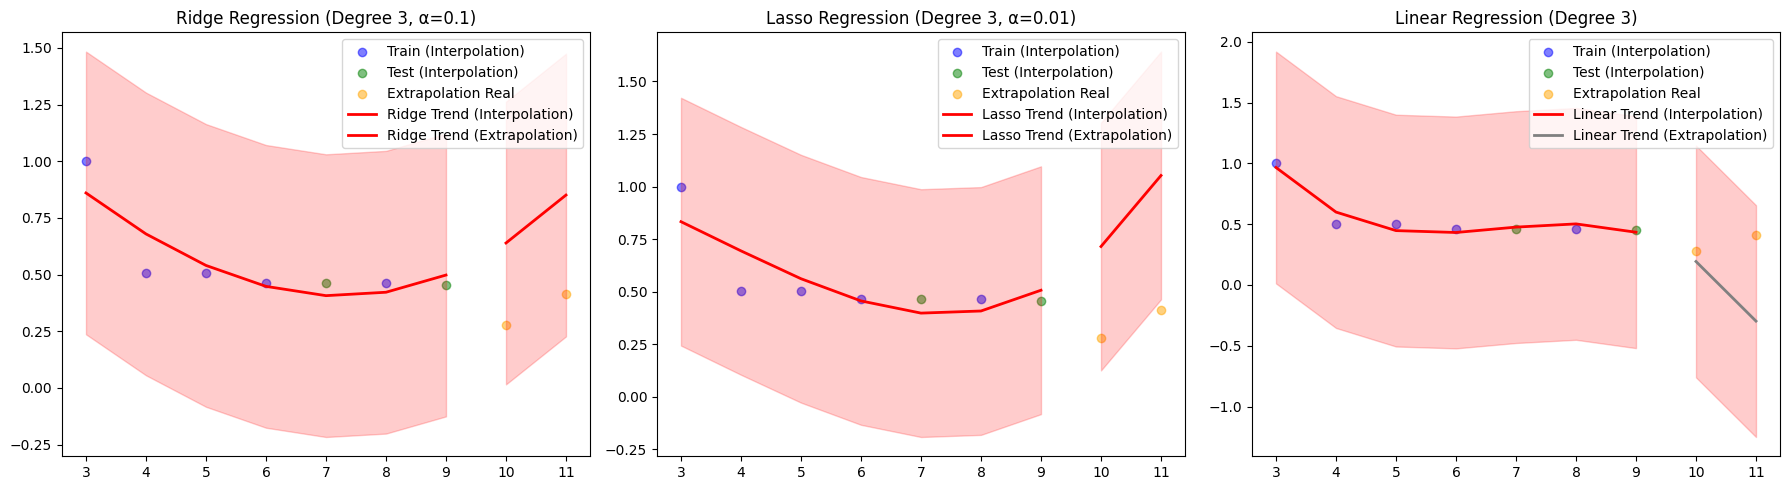

Degree 3: Ridge (α=0.1, MSE=-0.7743),R2_Score=-8.8831, R2_Score_Extrapolation=-34.92697618700935
Degree 3: Lasso (α=0.01, MSE=-0.7521),R2_Score=-7.7428, R2_Score_Extrapolation=-65.8208083037496
Degree 3: Linear (MSE=-0.0548),R2_Score=-26.8342, R2_Score_Extrapolation=-55.92259388963918


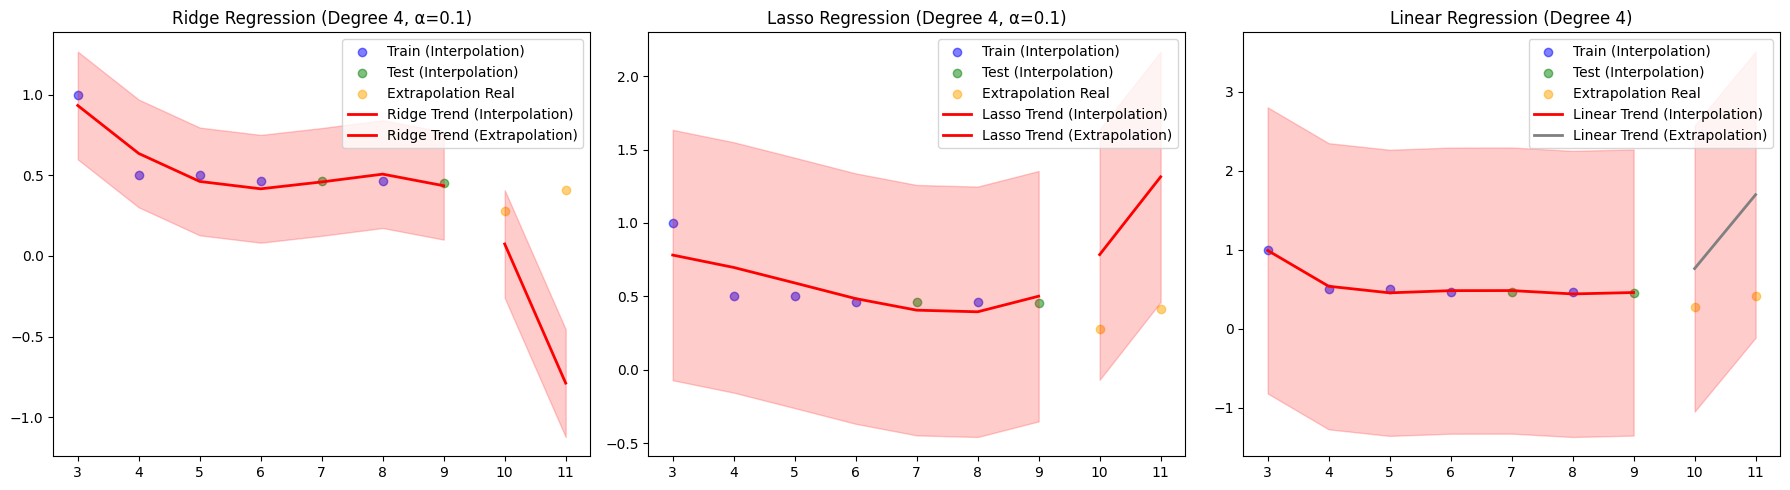

Degree 4: Ridge (α=0.1, MSE=-0.6218),R2_Score=-1.6401, R2_Score_Extrapolation=-164.44345361942402
Degree 4: Lasso (α=0.1, MSE=-0.8940),R2_Score=-18.1852, R2_Score_Extrapolation=-118.16043995991369
Degree 4: Linear (MSE=0.3481),R2_Score=-95.8570, R2_Score_Extrapolation=-208.99812825239704


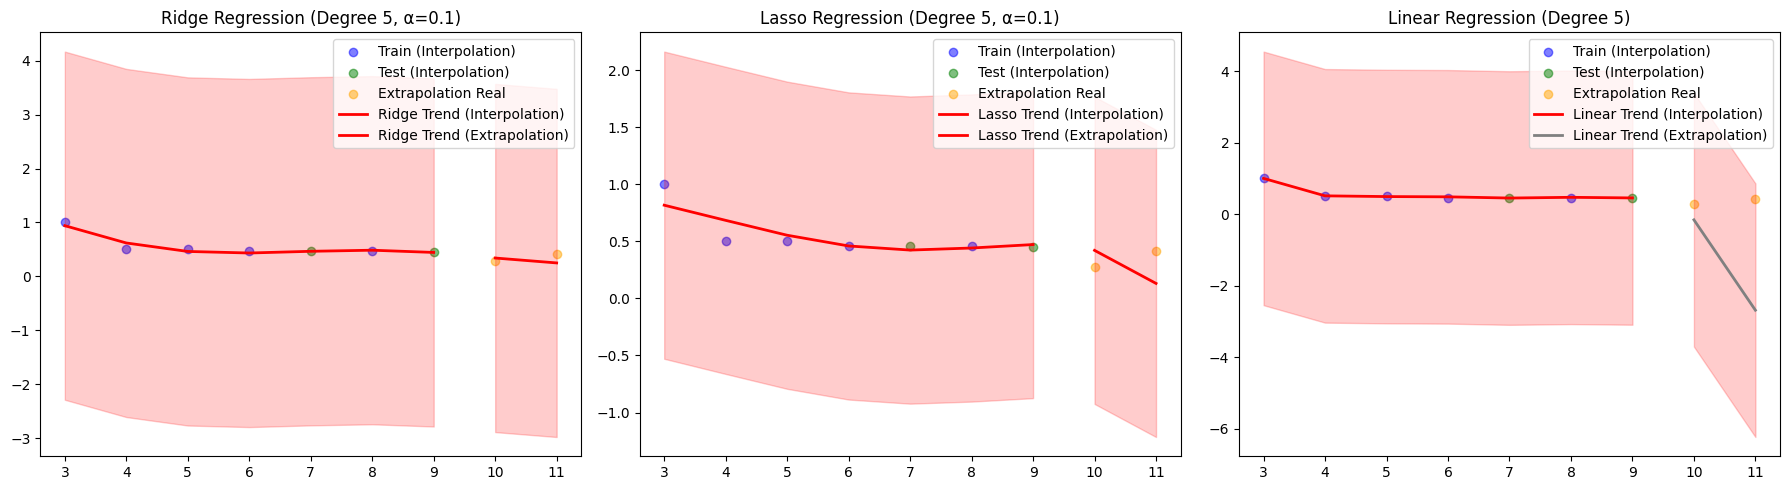

Degree 5: Ridge (α=0.1, MSE=1.0174),R2_Score=-301.8916, R2_Score_Extrapolation=-2.3628799781479914
Degree 5: Lasso (α=0.1, MSE=-1.1456),R2_Score=-48.5684, R2_Score_Extrapolation=-10.047992633180518
Degree 5: Linear (MSE=1.1750),R2_Score=-365.1687, R2_Score_Extrapolation=-1091.3770234132537


In [23]:
# Define parameters
poly_degree = [1, 2, 3, 4, 5]  # Polynomial degrees to test
alpha_values = [0.001, 0.01, 0.1]  # Regularization strengths
n_splits = 5  # Number of folds for cross-validation
random_state = 42  # Ensures reproducibility

df_train = df.dropna()  # Remove NaN values

# Convert to numpy arrays
X = np.array(df_train['Month_Num']).reshape(-1, 1)
y = np.array(df_train['Retention_Rate'])

# Split dataset into 80% interpolation and 20% extrapolation
X_interp, X_extrap, y_interp, y_extrap = train_test_split(X, y, test_size=0.2, random_state=random_state, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp, test_size=0.2, shuffle=True)

# K-Fold Cross Validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Loop through each polynomial degree
for degree in poly_degree:
    best_ridge_alpha, best_lasso_alpha = None, None
    best_ridge_model, best_lasso_model, best_linear_model = None, None, None
    best_ridge_R2_sklearn, best_lasso_R2_sklearn, best_linear_R2_sklearn = None, None, None
    best_ridge_mse, best_lasso_mse, best_linear_mse = float('inf'), float('inf'), float('inf')

    # Loop through different alpha values for Ridge and Lasso
    for alpha in alpha_values:
        # Ridge Regression Model
        ridge_model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
        ridge_preds = cross_val_predict(ridge_model, X_train, y_train, cv=kf)
        ridge_std = np.std(y_train - ridge_preds)
        ridge_R2_sklearn = r2_score(y_train, ridge_preds)
               
        ridge_mse_scores = -cross_val_predict(ridge_model, X_train, y_train, cv=kf)
        ridge_mean_mse = np.mean(ridge_mse_scores)

        if ridge_mean_mse < best_ridge_mse:
            best_ridge_mse = ridge_mean_mse
            best_ridge_alpha = alpha
            best_ridge_model = ridge_model
            best_ridge_std = ridge_std
            best_ridge_R2_sklearn= ridge_R2_sklearn

        # Lasso Regression Model
        lasso_model = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha, max_iter=10000))
        lasso_preds = cross_val_predict(lasso_model, X_train, y_train, cv=kf)
        lasso_std = np.std(y_train - lasso_preds)
        lasso_R2_sklearn = r2_score(y_train, lasso_preds)

        lasso_mse_scores = -cross_val_predict(lasso_model, X_train, y_train, cv=kf)
        lasso_mean_mse = np.mean(lasso_mse_scores)

        if lasso_mean_mse < best_lasso_mse:
            best_lasso_mse = lasso_mean_mse
            best_lasso_alpha = alpha
            best_lasso_model = lasso_model
            best_lasso_std = lasso_std
            best_lasso_R2_sklearn= lasso_R2_sklearn
            
    # Linear Regression Model (no regularization)
    linear_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    linear_preds = cross_val_predict(linear_model, X_train, y_train, cv=kf)
    linear_std = np.std(y_train - linear_preds)
    linear_R2_sklearn = r2_score(y_train, linear_preds)

    
    linear_mse_scores = -cross_val_predict(linear_model, X_train, y_train, cv=kf)
    linear_mean_mse = np.mean(linear_mse_scores)

    best_linear_model = linear_model
    best_linear_std = linear_std
    best_linear_R2_sklearn= linear_R2_sklearn
    # Train the best models for this degree
    best_ridge_model.fit(X_interp, y_interp)
    best_lasso_model.fit(X_interp, y_interp)
    best_linear_model.fit(X_interp, y_interp)

    # Predictions
    ridge_y_predict_interp = best_ridge_model.predict(X_interp)
    ridge_y_predict_extra = best_ridge_model.predict(X_extrap)

    
    lasso_y_predict_interp = best_lasso_model.predict(X_interp)
    lasso_y_predict_extra = best_lasso_model.predict(X_extrap)
    
    
    linear_y_predict_interp = best_linear_model.predict(X_interp)
    linear_y_predict_extra = best_linear_model.predict(X_extrap)

    R2_sklearn_ridge = r2_score(y_extrap, ridge_y_predict_extra)
    R2_sklearn_lasso = r2_score(y_extrap, lasso_y_predict_extra)
    R2_sklearn_linear = r2_score(y_extrap, linear_y_predict_extra)

    # Plot results for this degree
    plt.figure(figsize=(18, 5))

    # Ridge Regression Plot
    plt.subplot(1, 3, 1)
    plt.scatter(X_train, y_train, label='Train (Interpolation)', color='blue', alpha=0.5)
    plt.scatter(X_test, y_test, label='Test (Interpolation)', color='green', alpha=0.5)
    plt.scatter(X_extrap, y_extrap, label='Extrapolation Real', color='orange', alpha=0.5)
    plt.plot(X_interp, ridge_y_predict_interp, label='Ridge Trend (Interpolation)', color='red', linewidth=2)
    plt.plot(X_extrap, ridge_y_predict_extra, label='Ridge Trend (Extrapolation)', color='red', linewidth=2)
    plt.fill_between(X_interp.flatten(), ridge_y_predict_interp - best_ridge_std, ridge_y_predict_interp + best_ridge_std, color='red', alpha=0.2)
    plt.fill_between(X_extrap.flatten(), ridge_y_predict_extra - best_ridge_std, ridge_y_predict_extra + best_ridge_std, color='red', alpha=0.2)
    plt.title(f'Ridge Regression (Degree {degree}, α={best_ridge_alpha})')
    plt.legend()

    # Lasso Regression Plot
    plt.subplot(1, 3, 2)
    plt.scatter(X_train, y_train, label='Train (Interpolation)', color='blue', alpha=0.5)
    plt.scatter(X_test, y_test, label='Test (Interpolation)', color='green', alpha=0.5)
    plt.scatter(X_extrap, y_extrap, label='Extrapolation Real', color='orange', alpha=0.5)
    plt.plot(X_interp, lasso_y_predict_interp, label='Lasso Trend (Interpolation)', color='red', linewidth=2)
    plt.plot(X_extrap, lasso_y_predict_extra, label='Lasso Trend (Extrapolation)', color='red', linewidth=2)
    plt.fill_between(X_interp.flatten(), lasso_y_predict_interp - best_lasso_std, lasso_y_predict_interp + best_lasso_std, color='red', alpha=0.2)
    plt.fill_between(X_extrap.flatten(), lasso_y_predict_extra - best_lasso_std, lasso_y_predict_extra + best_lasso_std, color='red', alpha=0.2)
    plt.title(f'Lasso Regression (Degree {degree}, α={best_lasso_alpha})')
    plt.legend()

    # Linear Regression Plot
    plt.subplot(1, 3, 3)
    plt.scatter(X_train, y_train, label='Train (Interpolation)', color='blue', alpha=0.5)
    plt.scatter(X_test, y_test, label='Test (Interpolation)', color='green', alpha=0.5)
    plt.scatter(X_extrap, y_extrap, label='Extrapolation Real', color='orange', alpha=0.5)
    plt.plot(X_interp, linear_y_predict_interp, label='Linear Trend (Interpolation)', color='red', linewidth=2)
    plt.plot(X_extrap, linear_y_predict_extra, label='Linear Trend (Extrapolation)', color='gray', linewidth=2)
    plt.fill_between(X_interp.flatten(), linear_y_predict_interp - best_linear_std, linear_y_predict_interp + best_linear_std, color='red', alpha=0.2)
    plt.fill_between(X_extrap.flatten(), linear_y_predict_extra - best_linear_std, linear_y_predict_extra + best_linear_std, color='red', alpha=0.2)
    plt.title(f'Linear Regression (Degree {degree})')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Degree {degree}: Ridge (α={best_ridge_alpha}, MSE={best_ridge_mse:.4f}),R2_Score={best_ridge_R2_sklearn:.4f}, R2_Score_Extrapolation={R2_sklearn_ridge}")
    print(f"Degree {degree}: Lasso (α={best_lasso_alpha}, MSE={best_lasso_mse:.4f}),R2_Score={best_lasso_R2_sklearn:.4f}, R2_Score_Extrapolation={R2_sklearn_lasso}")
    print(f"Degree {degree}: Linear (MSE={linear_mean_mse:.4f}),R2_Score={best_linear_R2_sklearn:.4f}, R2_Score_Extrapolation={R2_sklearn_linear}")
